In [103]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import os
from scipy.ndimage import gaussian_filter, convolve
from scipy.interpolate import interp2d
from scipy.signal import spline_filter, medfilt2d, savgol_filter
from skimage import restoration
import warnings
warnings.filterwarnings('ignore')


### Import the folder containing the data set

### SET DIRECTORY HERE

In [104]:
dir = r"C:\Users\physlab\Desktop\Sep_data\2D_Spt7"


### Once the directory is added, the next cell will read the files and sort them

In [105]:
def numOfValues():
    for count in range(1000000):
        if os.path.join(dir, os.listdir(dir)[count]).endswith('csv'):
            totalValues = pd.read_csv(os.path.join(dir, os.listdir(dir)[count])).shape[0]
            return totalValues

# Adding a dummy row
channel1 = np.zeros(numOfValues())
channel2 = np.zeros(numOfValues())

for file in os.listdir(dir):
    path = os.path.join(dir, file)
    if path.endswith('.csv'):
        df = pd.read_csv(path)
        channel1 = np.row_stack((channel1, df.iloc[:, 2].values))
        channel2 = np.row_stack((channel2, df.iloc[:, 3].values))

# Removing the dummy row
channel1 = channel1[1:][:] 
channel2 = channel2[1:][:]

### SET FREQUENCY BOUNDS HERE

In [106]:
# Important: Change these according to your sweep frequencies
freq_lowerbound = 2 # minimum value of frequency sweep
freq_upperbound = 8 # maximum value of frequency sweep

### Visualize Unfiltered Data

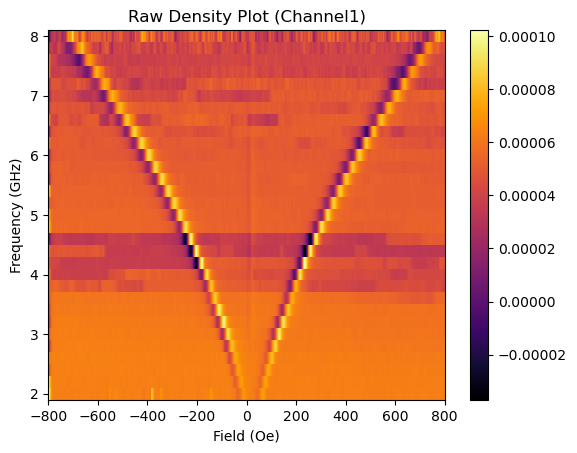

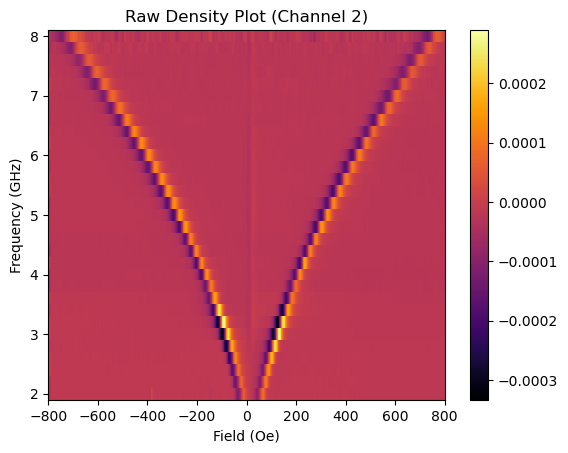

In [107]:
field = df.iloc[:, 1].values
freq = np.around(np.linspace(freq_lowerbound, freq_upperbound, channel1.shape[0]), decimals=2)

plt.title('Raw Density Plot (Channel1)')
plt.pcolormesh(field, freq, channel1, cmap='gist_heat')
plt.colorbar()
plt.xlabel('Field (Oe)')
plt.ylabel('Frequency (GHz)')
plt.show()

plt.title('Raw Density Plot (Channel 2)')
plt.pcolormesh(field, freq, channel2, cmap='gist_heat')
plt.colorbar()
plt.xlabel('Field (Oe)')
plt.ylabel('Frequency (GHz)')
plt.show()

### SET THE FREQUENCY & FIELD RANGE HERE

In [108]:
lower_freq = 2.0
upper_freq = 8.0
lower_field = -800
upper_field = 800

### The cell below contains different functions that filters the data which helps in plot smoothening. 
#### You can change the filter hyperparameters to test on your data set (the current parameters produced the best results for me)

In [109]:
def cut_freq(freq, lower_freq, upper_freq):
    lower_freq = math.ceil(len(freq)/(max(freq) - min(freq)) * (lower_freq - min(freq)))
    upper_freq = math.ceil(len(freq)/(max(freq) - min(freq)) * (upper_freq - min(freq)))
    return freq[lower_freq:upper_freq], lower_freq, upper_freq

def cut_field(field, lower_field, upper_field):
    lower_field = math.ceil(len(field)/(max(field) - min(field)) * (lower_field - min(field)))
    upper_field = math.ceil(len(field)/(max(field) - min(field)) * (upper_field - min(field)))
    return field[lower_field:upper_field], lower_field, upper_field

def integrate(xarr, varr, c=0.0):
    varr = varr - np.mean(varr)
    intg_x = np.insert(xarr, 0, xarr[0] - (xarr[1] - xarr[0]))
    intg_y = np.array([c])

    for i in range(len(xarr)):
        dydx = varr[i]
        intg_y = np.append(intg_y, dydx * (intg_x[i + 1] - intg_x[i]) + intg_y[i])
    return intg_x[1:], intg_y[1:]

# 4 filters: whichever filter produces the best results can be used
def filter(fil, channel):
    if fil == 'gaussian':
        smoothed_data = gaussian_filter(channel, sigma=0.7)
    elif fil == 'median':
        smoothed_data = medfilt2d(channel, kernel_size=[1,3])
    elif fil == 'spline':
        smoothed_data = spline_filter(channel, 1)
    elif fil == 'savgol':
        smoothed_data = savgol_filter(channel, 20, 10, mode='nearest')
    elif fil == 'fft':
        fft_result = np.fft.fft2(channel)
        fft_result[np.abs(fft_result) < np.percentile(np.abs(fft_result), 96)] = 0
        smoothed_data = np.fft.ifft2(fft_result).real
    elif fil == 'None':
        smoothed_data = channel
    return smoothed_data

def apply_laplacian_regularization(smoothed_data, reg_strength):
    laplacian = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
    regularized_data = smoothed_data + reg_strength * convolve(smoothed_data, laplacian, mode='nearest')
    return regularized_data

def smoothed_plot(field, freq, channel, filter_type, second_filter_type='None', reg_strength=0.1):
    # Increase the number of points for a higher resolution
    n = len(field_used)
    x_new = np.linspace(field.min(), field.max(), n)
    y_new = np.linspace(freq.min(), freq.max(), n)
    field_new, freq_new = np.meshgrid(x_new, y_new)

    # Data processing
    smoothed_data = filter(filter_type, channel)
    smoothed_data = apply_laplacian_regularization(smoothed_data, reg_strength)
    smoothed_data = restoration.denoise_nl_means(smoothed_data, h=0.000001)

    if second_filter_type != 'None':
        smoothed_data = filter(second_filter_type, smoothed_data)

    # Interpolation
    interp_func = interp2d(field, freq, smoothed_data, kind='cubic')
    data = interp_func(x_new, y_new)

    # Plotting
    plt.pcolormesh(field_new, freq_new, data, cmap='gist_heat')
    plt.colorbar()
    plt.xlabel('Field (Oe)')
    plt.ylabel('Frequency (GHz)')

    return data

freq_used = cut_freq(freq, lower_freq, upper_freq)[0]
lower_freq = cut_freq(freq, lower_freq, upper_freq)[1]
upper_freq = cut_freq(freq, lower_freq, upper_freq)[2]

field_used = cut_field(field, lower_field, upper_field)[0]
lower_field = cut_freq(field, lower_field, upper_field)[1]
upper_field = cut_freq(field, lower_field, upper_field)[2]

# Choosing the channel type
def channel(type, minfreq=lower_freq, maxfreq=upper_freq, minfield=lower_field, maxfield=upper_field):
    if type == 1:
        return channel1[minfreq:maxfreq, minfield:maxfield]
    elif type == 2:
        return channel2[minfreq:maxfreq, minfield:maxfield]

### Visualizing Filtered Data
#### 1. Test different filters
#### 2. You can also apply two filters or no filter at all (use second_filter_type or 'None', respectively)
#### 3. Set the channel type accordingly

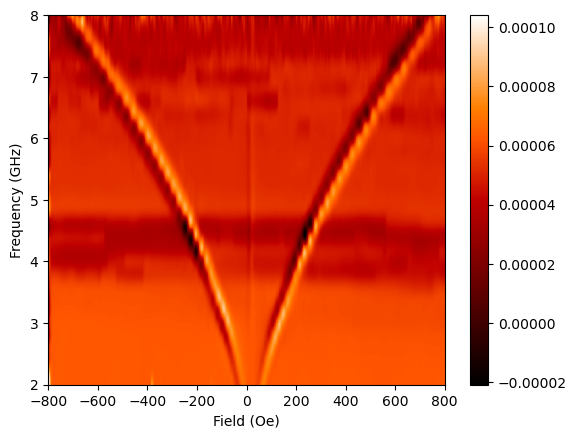

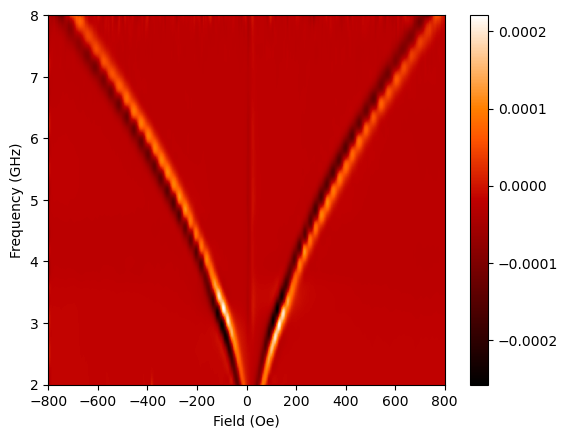

In [110]:
# Channel 1
c1 = smoothed_plot(field_used, freq_used, channel(1), filter_type='gaussian', second_filter_type='savgol')
plt.show()

# Channel 2
c2 = smoothed_plot(field_used, freq_used, channel(2), filter_type='gaussian', second_filter_type='savgol')
plt.show()


### Integrated Raw Plots

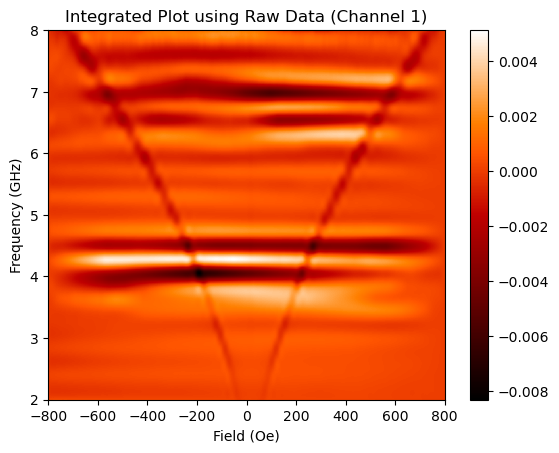

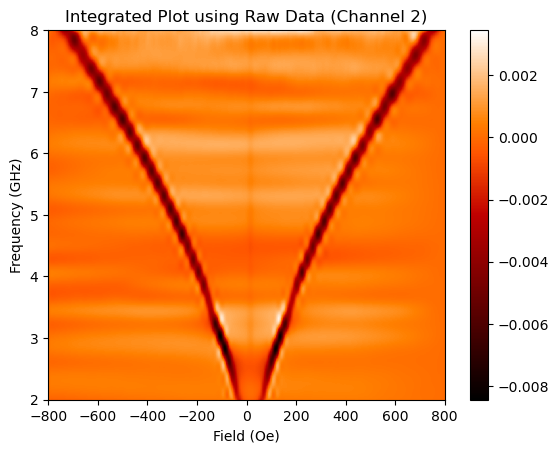

In [120]:
################## Channel 1 ###################

Z = channel1
integrated = np.zeros(len(field_used))

for i in range(1, Z.shape[0]):
    integrated = np.row_stack((integrated, integrate(field_used, Z[i])[1]))
integrated = integrated[1:]

integrated = smoothed_plot(
    np.linspace(round(min(field_used)), round(max(field_used)), integrated.shape[1]), 
    np.linspace(min(freq_used), max(freq_used), integrated.shape[0]),
    integrated, filter_type='None', second_filter_type='None'
             )

plt.title('Integrated Plot using Raw Data (Channel 1)')
plt.show()

################## Channel 2 ###################

Z = channel2
integrated = np.zeros(len(field_used))

for i in range(1, Z.shape[0]):
    integrated = np.row_stack((integrated, integrate(field_used, Z[i])[1]))
integrated = integrated[1:]

integrated = smoothed_plot(
    np.linspace(round(min(field_used)), round(max(field_used)), integrated.shape[1]), 
    np.linspace(min(freq_used), max(freq_used), integrated.shape[0]),
    integrated, filter_type='savgol', second_filter_type='None'
             )

plt.title('Integrated Plot using Raw Data (Channel 2)')
plt.show()

### Integrated Filtered Plots

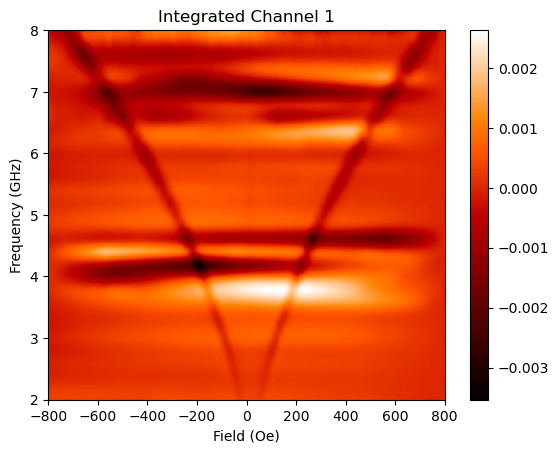

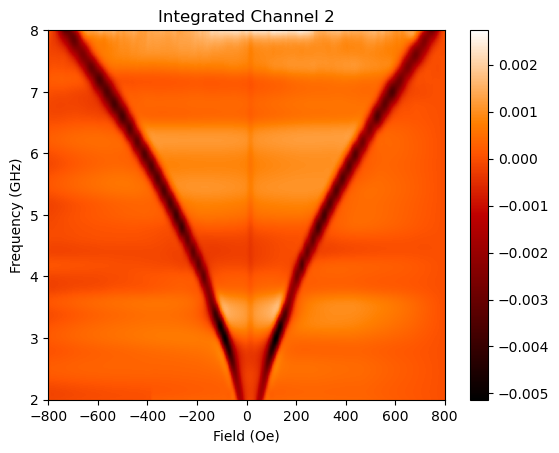

In [117]:
################## Channel 1 ###################

Z = c1
integrated = np.zeros(Z.shape[1])

for i in range(1, Z.shape[0]):
    integrated = np.row_stack((integrated, integrate(field_used, Z[i])[1]))
integrated = integrated[1:]

integrated = smoothed_plot(
    np.linspace(round(min(field_used)), round(max(field_used)), integrated.shape[1]), 
    np.linspace(min(freq_used), max(freq_used), integrated.shape[0]),
    integrated, filter_type='fft', second_filter_type='savgol'
             )
plt.title('Integrated Channel 1')
plt.show()

################## Channel 2 ###################

Z = c2
integrated = np.zeros(Z.shape[1])

for i in range(1, Z.shape[0]):
    integrated = np.row_stack((integrated, integrate(field_used, Z[i])[1]))
integrated = integrated[1:]

integrated = smoothed_plot(
    np.linspace(round(min(field_used)), round(max(field_used)), integrated.shape[1]), 
    np.linspace(min(freq_used), max(freq_used), integrated.shape[0]),
    integrated, filter_type='None', second_filter_type='None'
             )
plt.title('Integrated Channel 2')
plt.show()